In [1]:
from sklearn.datasets import load_digits

import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import joblib

import warnings

**Define libraries parameters**

In [ ]:
warnings.filterwarnings("ignore")

**Define project constants**

In [3]:
RANDOM_STATE=42

In [4]:
X,y = load_digits(return_X_y=True)

In [5]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [25]:
y

array([0, 1, 2, ..., 8, 9, 8])

**Splitting in training and test split**

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=RANDOM_STATE,stratify=y)

**Creatin Pipeline with scaling and model**

In [8]:
base_pipeline=Pipeline(
    [
    ("Scaler", MinMaxScaler()),
    ("Model",RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=RANDOM_STATE))
]
)
base_pipeline.fit(X=X_train,y=y_train)

Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('Model',
                 RandomForestClassifier(n_jobs=-1, oob_score=True,
                                        random_state=42))])

In [9]:
y_train_pred = base_pipeline.predict(X_train)

**Show classification report of the forest**

In [10]:
report= classification_report(y_true=y_train, y_pred=y_train_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       1.00      1.00      1.00       146
           2       1.00      1.00      1.00       142
           3       1.00      1.00      1.00       146
           4       1.00      1.00      1.00       145
           5       1.00      1.00      1.00       145
           6       1.00      1.00      1.00       145
           7       1.00      1.00      1.00       143
           8       1.00      1.00      1.00       139
           9       1.00      1.00      1.00       144

    accuracy                           1.00      1437
   macro avg       1.00      1.00      1.00      1437
weighted avg       1.00      1.00      1.00      1437



**Perfroming cross validation on base pipeline**

In [11]:
skfold=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

In [12]:
base_cv_scores= cross_val_score(estimator=base_pipeline, X=X_train,
y=y_train, scoring="accuracy",cv=skfold, n_jobs=-1,verbose=1)
base_cv_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished


array([0.96527778, 0.98611111, 0.97222222, 0.98611111, 0.97222222,
       0.99305556, 0.96527778, 0.97202797, 0.97902098, 0.97902098])

In [13]:
base_pipeline.named_steps

{'Scaler': MinMaxScaler(),
 'Model': RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)}

In [14]:
params={
    "Model__n_estimators" : [50,100,200,250,500],
    "Model__criterion" : ["gini","entropy"],
    "Model__max_features": ["sqrt","log"],
    "Model__class_weight": [None,"balanced"]
}

**Hyper parameters optimization**

In [15]:

random_search= RandomizedSearchCV(estimator=base_pipeline, param_distributions=params,
                            scoring="accuracy",n_jobs=-1,n_iter=20,cv=skfold, verbose=True,)
random_search.fit(X=X_train,y=y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('Scaler', MinMaxScaler()),
                                             ('Model',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     oob_score=True,
                                                                     random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'Model__class_weight': [None,
                                                                'balanced'],
                                        'Model__criterion': ['gini', 'entropy'],
                                        'Model__max_features': ['sqrt', 'log'],
                                        'Model__n_estimators': [50, 100, 200,
                                                                250, 500]},
                   scoring='accuracy', verbose=True)

In [16]:
random_search.best_params_

{'Model__n_estimators': 250,
 'Model__max_features': 'sqrt',
 'Model__criterion': 'gini',
 'Model__class_weight': None}

**Creating best model pipeline**

In [17]:
best_pipeline=Pipeline(
    [
    ("Scaler", MinMaxScaler()),
    ("Model",RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=RANDOM_STATE, class_weight= 'balanced'))
]
)
best_pipeline.fit(X=X_train,y=y_train)

Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('Model',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        oob_score=True, random_state=42))])

In [18]:
best_cv_scores= cross_val_score(estimator=best_pipeline, X=X_train,
y=y_train, scoring="accuracy",cv=skfold, n_jobs=-1,verbose=1)
best_cv_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


array([0.95138889, 0.99305556, 0.98611111, 0.97916667, 0.95833333,
       0.99305556, 0.96527778, 0.96503497, 0.97202797, 0.97902098])

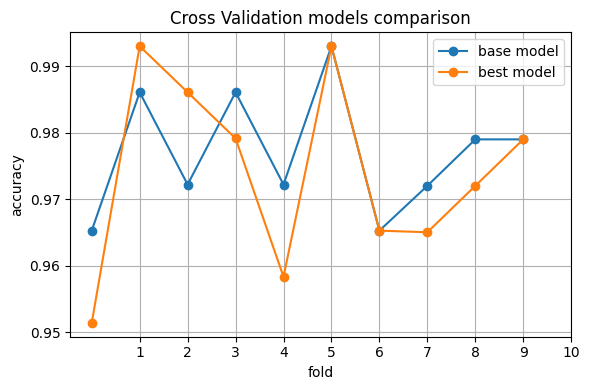

In [19]:
plt.figure(figsize=(6,4))
plt.title("Cross Validation models comparison")
plt.plot(base_cv_scores, marker="o")
plt.plot(best_cv_scores, marker="o")
plt.legend(["base model","best model"])
plt.xticks(ticks=range(1,11))
plt.xlabel("fold")
plt.ylabel("accuracy")
plt.grid()
plt.tight_layout()
plt.show()

**Check model performance on test set**

In [20]:
y_pred= best_pipeline.predict(X=X_test)

In [21]:
report= classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       0.92      0.97      0.95        36
           2       1.00      0.97      0.99        35
           3       0.97      0.97      0.97        37
           4       0.97      1.00      0.99        36
           5       0.97      1.00      0.99        37
           6       1.00      0.97      0.99        36
           7       0.97      1.00      0.99        36
           8       0.97      0.91      0.94        35
           9       0.97      0.94      0.96        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



**Serialize best pipeline**

In [22]:
joblib.dump(value=best_pipeline, filename="models/digit_pipeline.joblib")

['models/digit_pipeline.joblib']